IMplementation of VGG 19 on my Custom Taco Dataset.

Referred from the VGG19 pretrained model for Fashion dataset FMNIST
https://github.com/khanhnamle1994/fashion-mnist/blob/master/VGG19-GPU.ipynb

In [182]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from matplotlib import pyplot

# Data Processing 
import os
import os.path
import random
import PIL
import glob
from PIL import Image # to read images


In [183]:
# For Data Spltting
from sklearn.model_selection import train_test_split
# Import classifiers and performance metrics
from sklearn import svm, metrics

In [184]:
#For Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
import tensorflow as tf

### Dataset Preparation 

In [320]:
dataset_path = './data'
anns_file_path = dataset_path + '/' + 'annotations.json'

In [321]:
# Read Annotations
with open(anns_file_path , 'r') as f:
    dataset = json.loads(f.read())

In [322]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

1500


In [323]:
# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

In [324]:
# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

In [325]:
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000006.jpg,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,batch_1/000012.jpg,"[[481.0, 1148.0, 505.0, 1163.0, 519.0, 1172.0,...",43489.0,"[379.0, 1127.0, 425.0, 318.0]",0,Glass bottle
2,batch_1/000048.jpg,"[[586.0, 820.0, 581.0, 851.0, 579.0, 889.0, 58...",324005.0,"[211.0, 1.0, 417.0, 1417.0]",0,Glass bottle
3,batch_1/000021.jpg,"[[1001.0, 867.0, 1163.0, 905.0, 1199.0, 913.0,...",95494.5,"[852.0, 638.0, 687.0, 291.0]",0,Glass bottle
4,batch_1/000022.jpg,"[[919.0, 1125.0, 968.0, 1111.0, 1000.0, 1100.0...",142823.0,"[647.0, 1033.0, 820.0, 376.0]",0,Glass bottle


In [326]:
# New Dataframe with selective columns
df = final_merged_df[['filename','bbox','category']]

In [327]:
# storing bounding box values as seperate columns
df = pd.concat([df , df['bbox'].apply(pd.Series)], axis = 1)
df.columns = ['filename','bbox','category', 'x_min','y_min','x_max', 'y_max'] # x_max : width and y_max : height
df = df.drop(['bbox',], axis=1)

In [328]:
# Calculate maximum x and maximum y points
df['x_max'] = df['x_max']+df['x_min']
df['y_max'] = df['y_max']+df['y_min']
# Convert float columns to integer
for col in  df.columns[2:]:
    df[col] = df[col].astype(int)
    

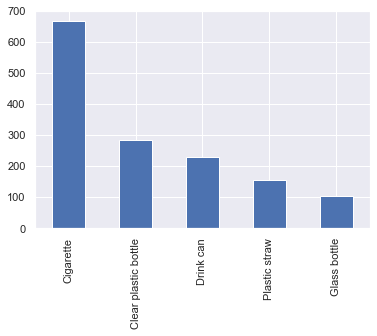

In [329]:
df['category'].value_counts().plot.bar()

In [330]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1442 entries, 0 to 1441
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1442 non-null   object
 1   category  1442 non-null   object
 2   x_min     1442 non-null   int64 
 3   y_min     1442 non-null   int64 
 4   x_max     1442 non-null   int64 
 5   y_max     1442 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 78.9+ KB
None


In [313]:
# Data splitting into train and test data and keep this test data aside for model prediction
train_df, test_df = train_test_split(df, test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [314]:
print(train_df.info())
print("    ")
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1297 non-null   object
 1   category  1297 non-null   object
 2   x_min     1297 non-null   int64 
 3   y_min     1297 non-null   int64 
 4   x_max     1297 non-null   int64 
 5   y_max     1297 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 60.9+ KB
None
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  145 non-null    object
 1   category  145 non-null    object
 2   x_min     145 non-null    int64 
 3   y_min     145 non-null    int64 
 4   x_max     145 non-null    int64 
 5   y_max     145 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 6.9+ KB
None


### Fetch, crop and store image data


In [331]:
# Reading all the images from multiple folders and added to the list
folders = glob.glob(dataset_path +'//*')
imagenames_list = []
for folder in folders:
    for f in glob.glob(folder+'/*'):   
        imagenames_list.append(f)

For train data

In [332]:
train_data = []  
for ind in df.index:
    bbox = (df['x_min'][ind],df['y_min'][ind],df['x_max'][ind],df['y_max'][ind])
    img=Image.open(os.path.join(dataset_path,df['filename'][ind]))
    img=img.crop(bbox)
    img = img.resize((150, 150), Image.ANTIALIAS)
    img = image.img_to_array(img)
    train_data.append(img)

X = np.array(train_data)

For test data

In [239]:
test_data = []  
for ind in test_df.index:
    bbox = (test_df['x_min'][ind],test_df['y_min'][ind],test_df['x_max'][ind],test_df['y_max'][ind])
    img=Image.open(os.path.join(dataset_path,test_df['filename'][ind]))
    img=img.crop(bbox)
    img = img.resize((150, 150), Image.ANTIALIAS)
    img = image.img_to_array(img)
    test_data.append(img)

X_test = np.array(test_data)


In [333]:
X.shape

(1442, 150, 150, 3)

As we have already fetched the cropped images, drop bounding boxed columns from the dataframe

In [334]:
#train_df = train_df.drop(['x_min','x_max','y_min','y_max'], axis=1)
df = df.drop(['x_min','x_max','y_min','y_max'], axis=1)

Convert categorical variables into dummy variables

In [335]:
#train_df = pd.get_dummies(train_df, columns=["category"])
df = pd.get_dummies(df, columns=["category"])

Drop the filename from the dataframe

In [336]:
y = np.array(df.drop(['filename'],axis=1))

Resize the images as 150 * 150 as required by VGG19

In [337]:
X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((150,150))) for im in X])

# Display the new shape
X.shape

(1442, 150, 150, 3)

In [338]:
# Normalise the data and change data type
X = X.astype('float32')
X /= 255

In [339]:
# Here I split original training data to sub-training (80%) and validation data (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=0.1)

# Check the data size whether it is as per tensorflow and VGG19 requirement
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1297, 150, 150, 3), (145, 150, 150, 3), (1297, 5), (145, 5))

### keras VGG19 implementation

In [340]:
# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (150, 150, 3), classes = 5)

In [341]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [342]:
# Preprocessing the input 
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [343]:
# Extracting features
train_features = vgg19.predict(np.array(X_train), batch_size=30, verbose=1)
test_features = vgg19.predict(np.array(X_test), batch_size=30, verbose=1)

145/145 [==============================] - 22s 149ms/step


In [344]:
# Saving the features so that they can be used for future
np.savez("train_features", train_features, y_train)
np.savez("test_features", test_features, y_test)

In [345]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape)

(1297, 4, 4, 512) 
 (145, 4, 4, 512)


In [346]:
# Flatten extracted features
train_features = np.reshape(train_features, (1297, 4*4*512))
test_features = np.reshape(test_features, (145, 4*4*512))

In [347]:
test_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Model implementation

In [348]:
# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(5, activation="softmax"))

In [349]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                

In [350]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

### Training the Model

In [351]:
# Train the the model
history = model.fit(train_features, y_train,
          batch_size=30,
          epochs=100,
          verbose=1,
          validation_split=0.2)

Train on 1037 samples, validate on 260 samples
Epoch 1/100
1037/1037 [==============================] - 1s 1ms/step - loss: 2.5449 - accuracy: 0.2527 - val_loss: 1.4896 - val_accuracy: 0.4654
Epoch 2/100
1037/1037 [==============================] - 1s 867us/step - loss: 1.5314 - accuracy: 0.3742 - val_loss: 1.4280 - val_accuracy: 0.4654
Epoch 3/100
1037/1037 [==============================] - 1s 838us/step - loss: 1.4708 - accuracy: 0.4156 - val_loss: 1.4117 - val_accuracy: 0.4654
Epoch 4/100
1037/1037 [==============================] - 1s 1ms/step - loss: 1.4574 - accuracy: 0.4503 - val_loss: 1.4047 - val_accuracy: 0.4654
Epoch 5/100
1037/1037 [==============================] - 1s 1ms/step - loss: 1.4393 - accuracy: 0.4609 - val_loss: 1.3859 - val_accuracy: 0.4654
Epoch 6/100
1037/1037 [==============================] - 1s 860us/step - loss: 1.4107 - accuracy: 0.4619 - val_loss: 1.4031 - val_accuracy: 0.4654
Epoch 7/100
1037/1037 [==============================] - 1s 862us/step - loss

1037/1037 [==============================] - 1s 884us/step - loss: 1.3566 - accuracy: 0.4648 - val_loss: 1.3075 - val_accuracy: 0.4654
Epoch 57/100
1037/1037 [==============================] - 1s 926us/step - loss: 1.3510 - accuracy: 0.4648 - val_loss: 1.3070 - val_accuracy: 0.4654
Epoch 58/100
1037/1037 [==============================] - 1s 889us/step - loss: 1.3642 - accuracy: 0.4648 - val_loss: 1.3283 - val_accuracy: 0.4654
Epoch 59/100
1037/1037 [==============================] - 1s 1ms/step - loss: 1.3576 - accuracy: 0.4648 - val_loss: 1.2983 - val_accuracy: 0.4654
Epoch 60/100
1037/1037 [==============================] - 1s 1ms/step - loss: 1.3482 - accuracy: 0.4648 - val_loss: 1.3210 - val_accuracy: 0.4654
Epoch 61/100
1037/1037 [==============================] - 1s 970us/step - loss: 1.3426 - accuracy: 0.4648 - val_loss: 1.2945 - val_accuracy: 0.4654
Epoch 62/100
1037/1037 [==============================] - 1s 853us/step - loss: 1.3652 - accuracy: 0.4648 - val_loss: 1.3057 - va

In [352]:

score = model.evaluate(test_features, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3151687104126504
Test accuracy: 0.4413793087005615


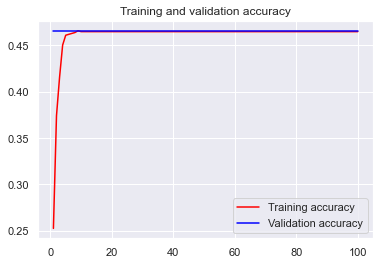

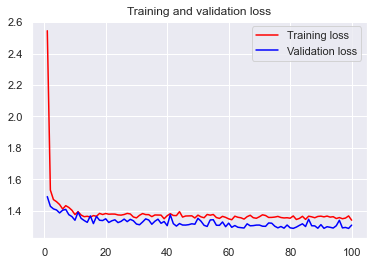

In [353]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training accuracy')
plt.plot(epochs, val_acc, 'blue', label='Validation accuracy')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

### Model Prediction Class Wise

In [358]:
classes = np.array(df.columns[1:])
proba = model.predict(test_features)

In [359]:
all_5 = np.argsort(proba[0])
for i in range(5):
    print("{}".format(classes[all_5[i]])+" ({:.3})".format(proba[0][all_5[i]]))

category_Glass bottle (0.103)
category_Plastic straw (0.125)
category_Drink can (0.174)
category_Clear plastic bottle (0.218)
category_Cigarette (0.381)
